In [45]:
'''
@Author: Stefan Angelov
@Created: 04/23/2021
@Purpose: Predicting the air pollution
'''

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import math
import datetime
from math import sqrt
import glob
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.display.max_columns = 100

# EDA on one suburbs

In [46]:
path = 'data/PRSA_Data_Aotizhongxin_20130301-20170228.csv'

def parse(x):
    return datetime.datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv(path, parse_dates = [['year', 'month', 'day', 'hour']],index_col=0, date_parser=parse)
dataset.columns = ['No','PM2.5', 'PM10', 'SO2', 'NO2',
       'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']
dataset.index = pd.to_datetime(dataset.index)

print(f'shape: {dataset.shape}')
dataset.head(5)

shape: (35064, 14)


,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
year_month_day_hour,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,2,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,3,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,4,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,5,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


Text(0.5, 1.0, 'Count of PM2.5 by Day')

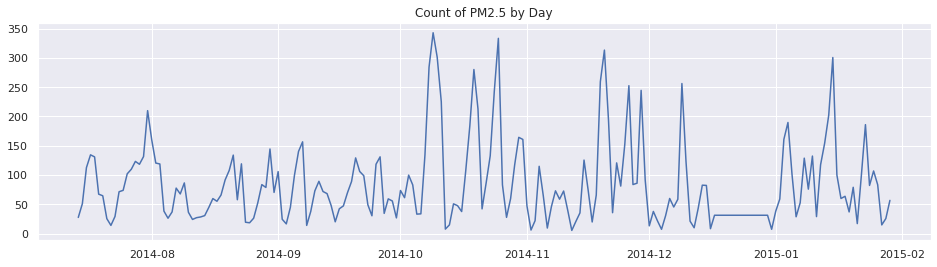

In [47]:
# plot the avg daily PM2.5
data_daily = dataset['PM2.5'].resample('D').mean()
data_daily.columns = 'PM2.5'
data_daily = data_daily.ffill()
logins_daily = data_daily[500:700]
# seasonal patter, cyclical, maybe a lot of fire at this part of the year
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(logins_daily)
ax.set_title("Count of PM2.5 by Day")

Text(0.5, 1.0, 'Count of PM2.5 by Month')

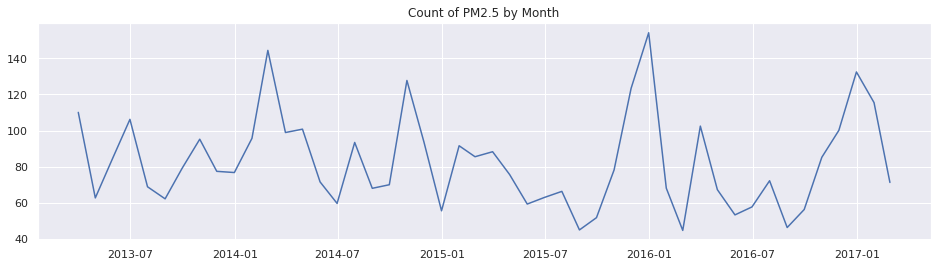

In [48]:
# plot the avg by month PM2.5
data_monthly = dataset['PM2.5'].resample('M').mean()
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_monthly)
ax.set_title("Count of PM2.5 by Month")

Text(0.5, 1.0, 'Count of PM2.5 by Year')

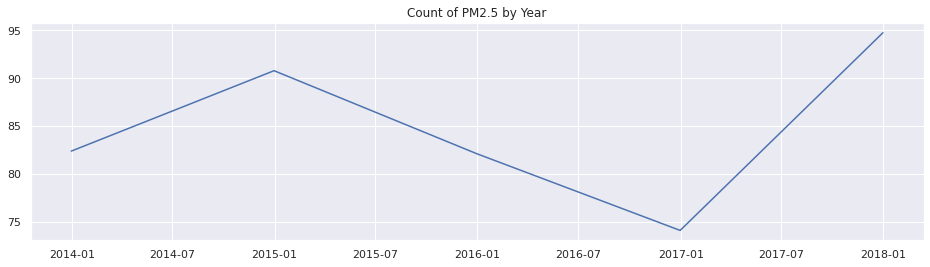

In [49]:
# plot the avg by month PM2.5
data_yearly = dataset['PM2.5'].resample('Y').mean()
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_yearly)
ax.set_title("Count of PM2.5 by Year")

Text(0.5, 1.0, 'Count of PM2.5 by 3 Days')

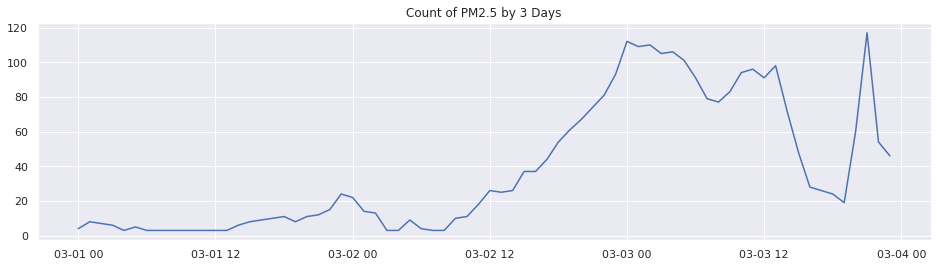

In [50]:
data_hourly_3_days = dataset['PM2.5'][:72]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly_3_days)
ax.set_title("Count of PM2.5 by 3 Days")

Text(0.5, 1.0, 'Count of PM2.5 by 4 Days')

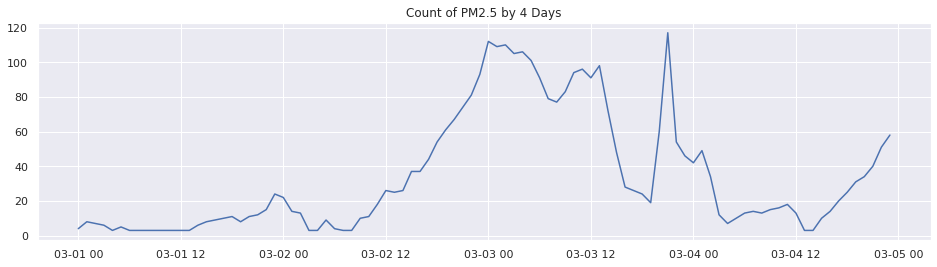

In [51]:
# plot the avg by month PM2.5
data_hourly_first_4_days = dataset['PM2.5'][:96]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly_first_4_days)
ax.set_title("Count of PM2.5 by 4 Days")

Text(0.5, 1.0, 'Count of PM2.5 by 4 Days')

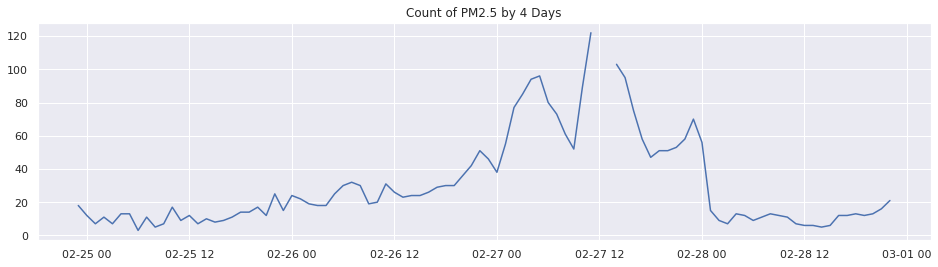

In [52]:
data_hourly_last_4_days = dataset['PM2.5'][-97:-1]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly_last_4_days)
ax.set_title("Count of PM2.5 by 4 Days")

Text(0.5, 1.0, 'Count of PM2.5 by Hour')

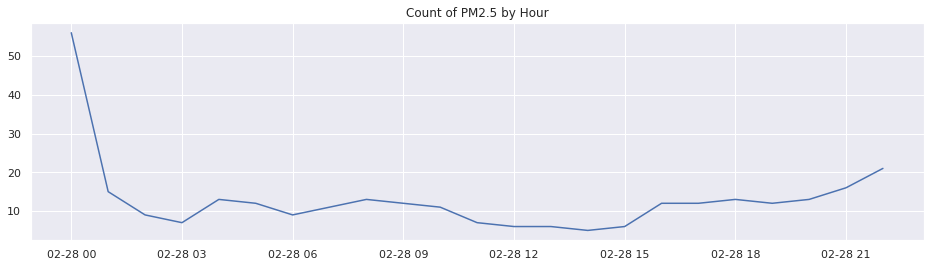

In [53]:
data_hourly = dataset['PM2.5'].resample('H').mean()
data_hourly = data_hourly[-24:-1]
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(data_hourly)
ax.set_title("Count of PM2.5 by Hour")

I want to see if I can pick out any immediate trends. Zoom in on different time scales and do some exploration to see what you can figure out.
It looks like there could be some structured behaviour in the weeks themselves, i.e. some signal from the day of week. Let's view a few different weeks.

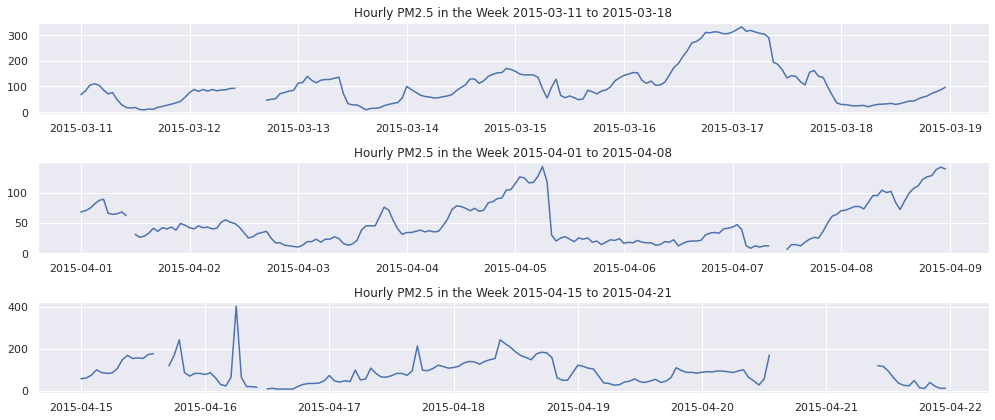

In [54]:
fig, axs = plt.subplots(3, figsize=(14, 6))
logins_hourly = dataset[['PM2.5']]
begin_dates = ['2015-03-11', '2015-04-01', '2015-04-15']
end_dates = ['2015-03-18', '2015-04-08', '2015-04-21']

for ax, begin_date, end_date in zip(axs, begin_dates, end_dates):
    logins_week = logins_hourly.loc[begin_date:end_date]
    ax.plot(logins_week)
    ax.set_title("Hourly PM2.5 in the Week {} to {}".format(
        begin_date, end_date))
    
fig.tight_layout()

In [55]:
logins_df = pd.DataFrame(index=logins_daily.index)
logins_df['count'] = logins_daily
logins_df['day_of_week'] = logins_daily.index.weekday
logins_df.head()

,count,day_of_week
year_month_day_hour,,
2014-07-14,27.666667,0
2014-07-15,51.083333,1
2014-07-16,112.750000,2
2014-07-17,134.541667,3
2014-07-18,131.045455,4


In [56]:
is_weekend = (logins_df['day_of_week'] == 5) + (logins_df['day_of_week'] == 6)
logins_df.head()

,count,day_of_week
year_month_day_hour,,
2014-07-14,27.666667,0
2014-07-15,51.083333,1
2014-07-16,112.750000,2
2014-07-17,134.541667,3
2014-07-18,131.045455,4


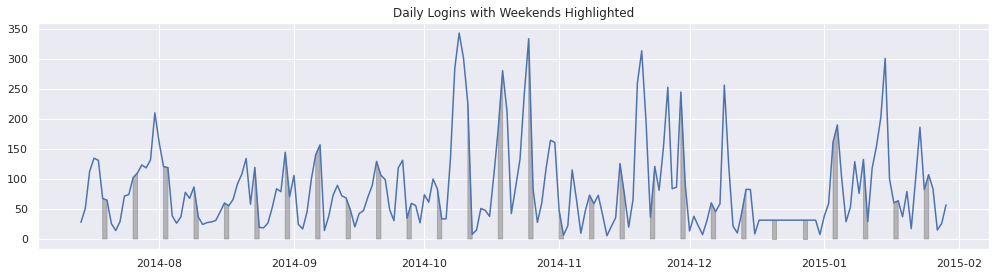

In [57]:
fig, ax = plt.subplots(1, figsize=(14, 4))

ax.plot(logins_df.index.values, logins_df['count'])

ax.fill_between(logins_df.index, 0, logins_df['count'], 
                where=is_weekend, color='grey', alpha=0.5)
ax.set_title("Daily Logins with Weekends Highlighted")

fig.tight_layout()

### Check for stationarity

In [58]:
# Split data
nobs = 4
df_train, df_test = data_daily[0:-nobs], data_daily[-nobs:]

# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
# results = adfuller(data_daily['data_daily_diff'][1:].values)
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train)
# rejecting the null p_value 0.00, it's stationary, there is no unit root

Test Statistic         -1.746269e+01
p-value                 4.588037e-30
# Lags                  2.000000e+00
# Observations          1.454000e+03
Critical Value (1%)    -3.434855e+00
Critical Value (5%)    -2.863530e+00
Critical Value (10%)   -2.567829e+00
dtype: float64
 Series is Stationary


# Part II EDA on the full 12 suburbs dataset
### Read Data
##### Read all CSV files from the data dir, sort files basis datetime and create train and test from the file

In [59]:
## Constants 
DATA_DIR = 'data'
TEST_SIZE = 0.2

## Walk Directory to list and read all csv file and append to consolidated data frame

train = pd.DataFrame()
test = pd.DataFrame()

expected_rows = 0

for file in os.listdir(DATA_DIR):
    if file.endswith(".csv"):
        print(f"Reading File.... {file}")
        
        file_path = os.path.join(DATA_DIR,file)
        file_data = pd.read_csv(file_path)
        
        expected_rows = expected_rows + file_data.shape[0]
        
        file_data['source_file'] = file.split('.')[0]
        
        # dropping rows where PM2.5 is NA as this the Target Variable
        file_data.dropna(subset=['PM2.5'],inplace=True)
        
        # create pandas datetime column for sorting the data basis datetime
        file_data['date'] = file_data.apply(lambda x : datetime.datetime(x['year'],x['month'],x['day'],x['hour']),axis=1)
        file_data = file_data.sort_values(['date'],ascending=True)

        # split into Train and Test so ensure Test size contains equal representatives from each location
        train_rows = int(file_data.shape[0] * (1-TEST_SIZE))+1
        file_train = file_data[:train_rows].copy()
        file_test = file_data[train_rows:].copy()
        
        train = pd.concat([train,file_train],ignore_index=True,sort=False,axis=0)
        test = pd.concat([test,file_test],ignore_index=True,sort=False,axis=0)

print(f"\n\nExpected No of rows {expected_rows} Actual No of rows {train.shape[0]+test.shape[0]}")
print(f"Train Shape {train.shape} and Test Shape {test.shape}")

Reading File.... PRSA_Data_Aotizhongxin_20130301-20170228.csv
Reading File.... PRSA_Data_Changping_20130301-20170228.csv
Reading File.... PRSA_Data_Dingling_20130301-20170228.csv
Reading File.... PRSA_Data_Dongsi_20130301-20170228.csv
Reading File.... PRSA_Data_Guanyuan_20130301-20170228.csv
Reading File.... PRSA_Data_Gucheng_20130301-20170228.csv
Reading File.... PRSA_Data_Huairou_20130301-20170228.csv
Reading File.... PRSA_Data_Nongzhanguan_20130301-20170228.csv
Reading File.... PRSA_Data_Shunyi_20130301-20170228.csv
Reading File.... PRSA_Data_Tiantan_20130301-20170228.csv
Reading File.... PRSA_Data_Wanliu_20130301-20170228.csv
Reading File.... PRSA_Data_Wanshouxigong_20130301-20170228.csv


Expected No of rows 420768 Actual No of rows 412029
Train Shape (329630, 20) and Test Shape (82399, 20)


## Preliminary Data Analysis - 
#### Descriptive stats, Data Type check and NA counts

In [60]:
train.head(3)

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,source_file,date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,PRSA_Data_Aotizhongxin_20130301-20170228,2013-03-01 02:00:00


In [61]:
train.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,329630.000000,329630.000000,329630.000000,329630.000000,329630.000000,329630.000000,329419.000000,326415.000000,323621.00000,315457.000000,322893.000000,329451.000000,329450.000000,329446.000000,329454.000000,329453.000000
mean,14008.462989,2014.276237,6.341707,15.649510,11.486312,80.128658,106.582811,17.507450,51.00092,1224.243149,57.510952,13.379369,1010.593266,2.036297,0.057417,1.735572
std,8103.426809,0.977026,3.412899,8.807066,6.932988,80.140547,91.492569,23.054222,35.00835,1123.715608,55.962359,11.217550,10.334996,13.695909,0.766661,1.275123
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.02650,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,6968.000000,2013.000000,3.000000,8.000000,5.000000,21.000000,37.000000,3.000000,23.00000,500.000000,11.781000,3.400000,1002.400000,-9.200000,0.000000,0.900000
50%,13995.500000,2014.000000,6.000000,16.000000,11.000000,56.000000,85.000000,8.000000,44.00000,900.000000,46.000000,14.300000,1010.200000,2.200000,0.000000,1.400000
75%,21025.750000,2015.000000,9.000000,23.000000,18.000000,112.000000,149.000000,22.000000,72.00000,1500.000000,82.000000,22.800000,1018.600000,14.700000,0.000000,2.200000
max,28152.000000,2016.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.00000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [62]:
train.describe(include=np.object)

,wd,station,source_file
count,328922,329630,329630
unique,16,12,12
top,NE,Wanliu,PRSA_Data_Wanliu_20130301-20170228
freq,31159,27746,27746


In [63]:
train.isna().sum()

No                 0
year               0
month              0
day                0
hour               0
PM2.5              0
PM10             211
SO2             3215
NO2             6009
CO             14173
O3              6737
TEMP             179
PRES             180
DEWP             184
RAIN             176
wd               708
WSPM             177
station            0
source_file        0
date               0
dtype: int64

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329630 entries, 0 to 329629
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   No           329630 non-null  int64         
 1   year         329630 non-null  int64         
 2   month        329630 non-null  int64         
 3   day          329630 non-null  int64         
 4   hour         329630 non-null  int64         
 5   PM2.5        329630 non-null  float64       
 6   PM10         329419 non-null  float64       
 7   SO2          326415 non-null  float64       
 8   NO2          323621 non-null  float64       
 9   CO           315457 non-null  float64       
 10  O3           322893 non-null  float64       
 11  TEMP         329451 non-null  float64       
 12  PRES         329450 non-null  float64       
 13  DEWP         329446 non-null  float64       
 14  RAIN         329454 non-null  float64       
 15  wd           328922 non-null  obje

In [65]:
train['station'].value_counts()

Wanliu           27746
Guanyuan         27559
Nongzhanguan     27549
Gucheng          27535
Tiantan          27510
Wanshouxigong    27495
Dongsi           27452
Changping        27433
Dingling         27429
Shunyi           27321
Aotizhongxin     27312
Huairou          27289
Name: station, dtype: int64

## Create Date from year, month data and hour column

In [66]:
train['date'].describe()

count                  329630
unique                  28097
top       2015-09-02 00:00:00
freq                       12
first     2013-03-01 00:00:00
last      2016-05-16 23:00:00
Name: date, dtype: object

## Fill NA's

For Numeric column fill Na with mean value for that city on that particular day where value is missing
<br>For Categorical column fill NA with mode value for that city on that particular day where value is missing

In [67]:
# create NA lookup table which conatains mean value for each station for each day of each month

na_lookup = train.groupby(['station','month','day']).agg({'PM10':'mean','SO2':'mean','NO2':'mean',
                                                          'CO':'mean','O3':'mean','TEMP':'mean',
                                                          'PRES':'mean','DEWP':'mean','RAIN':'mean',
                                                          'WSPM':'mean','wd':pd.Series.mode}).reset_index()

na_lookup.sample(3)

,station,month,day,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
3900,Wanliu,8,28,77.006944,7.509949,59.660987,972.222222,54.918841,24.522222,1001.613889,19.237500,0.138889,0.984722,NE
537,Changping,6,20,52.982759,3.829931,31.477412,551.111111,81.929231,25.053448,1000.167241,15.558621,0.170690,1.260345,N
2019,Gucheng,7,8,126.758065,7.177419,41.338710,937.704918,104.615816,27.969355,997.540323,19.393548,0.416129,0.874194,N


In [68]:
fill_cols = ['PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM','wd']

for col in fill_cols:
    merge_keys = ['station','month','day']
    lookup_cols = merge_keys + [col]
    
    na_df = train.loc[train[col].isna(),merge_keys]
    na_merge = na_df.merge(na_lookup[lookup_cols],how='left',on=merge_keys)
    
    train.loc[train[col].isna(),col] = na_merge[col].values

In [69]:
train.isna().sum().sum()

0

In [70]:
for col in fill_cols:
    merge_keys = ['station','month','day']
    lookup_cols = merge_keys + [col]
    
    na_df = test.loc[test[col].isna(),merge_keys]
    na_merge = na_df.merge(na_lookup[lookup_cols],how='left',on=merge_keys)
    
    test.loc[test[col].isna(),col] = na_merge[col].values

In [71]:
test.isna().sum().sum()

0

## Plotting Trend

In [72]:
num_col =  ['PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM']
trend = train.groupby(['station','year','month'])[num_col].mean().reset_index()
trend['date'] = trend.apply(lambda x : datetime.datetime(x['year'],x['month'],1),axis=1)
trend.head(3)

,station,year,month,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,date
0,Aotizhongxin,2013,3,143.947768,44.856064,74.752031,1468.271304,47.557084,6.053629,1012.547446,-5.729435,0.026210,2.000134,2013-03-01
1,Aotizhongxin,2013,4,108.204167,24.721549,53.183981,916.661724,51.161295,12.260694,1008.296944,-1.553611,0.015139,2.209722,2013-04-01
2,Aotizhongxin,2013,5,140.778976,30.377358,61.008086,929.380034,76.731235,21.371698,1003.149191,9.794340,0.007817,1.737736,2013-05-01


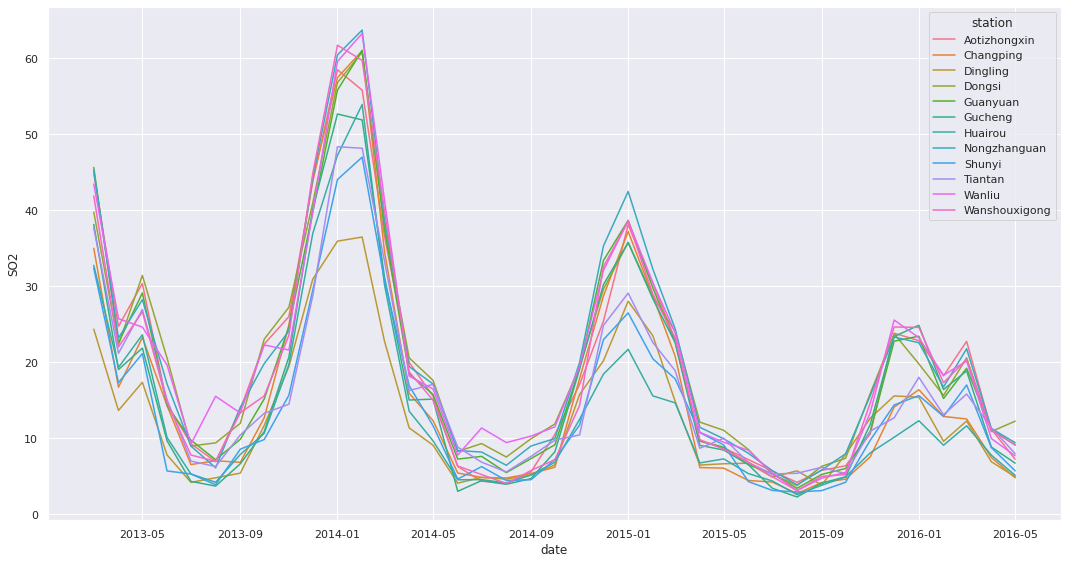

In [78]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="SO2",hue="station", data=trend)
plt.tight_layout()
plt.savefig("so2.png")

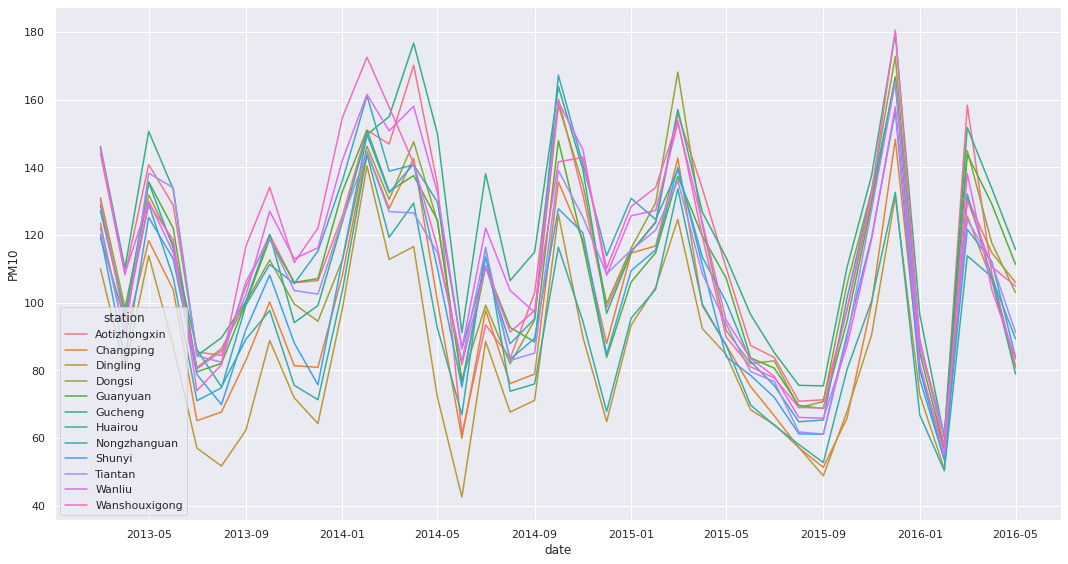

In [79]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="PM10",hue="station", data=trend)
plt.tight_layout()
plt.savefig("pm10.png")

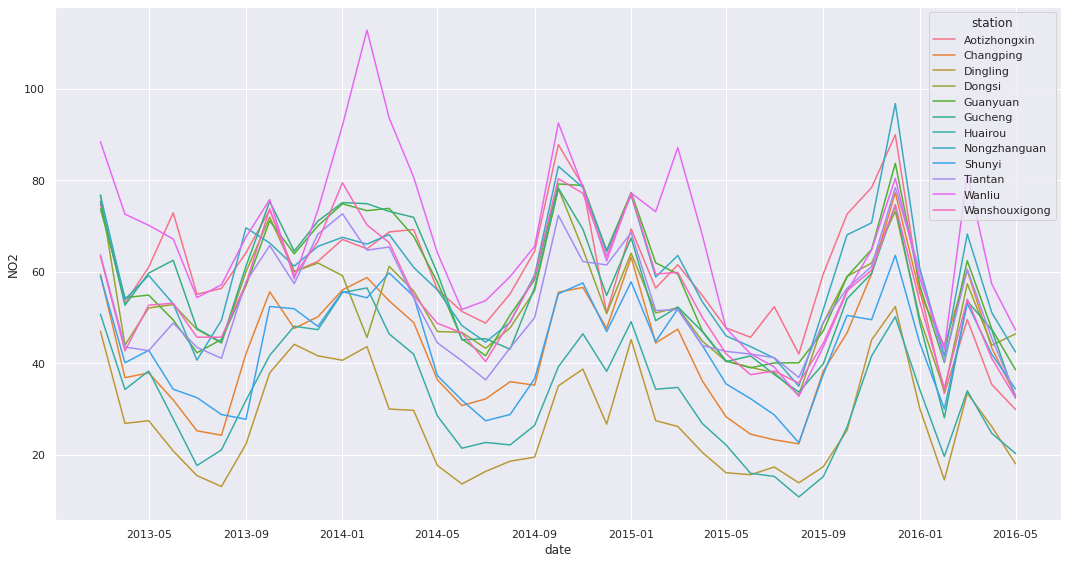

In [80]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="NO2",hue="station", data=trend)
plt.tight_layout()
plt.savefig("NO2.png")

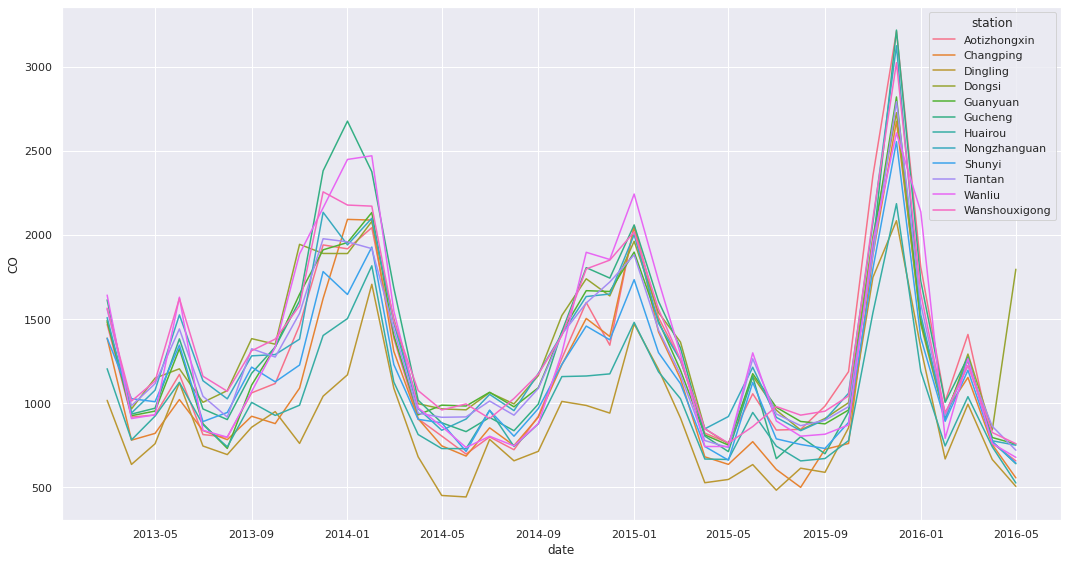

In [81]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="CO",hue="station", data=trend)
plt.tight_layout()
plt.savefig("co.png")

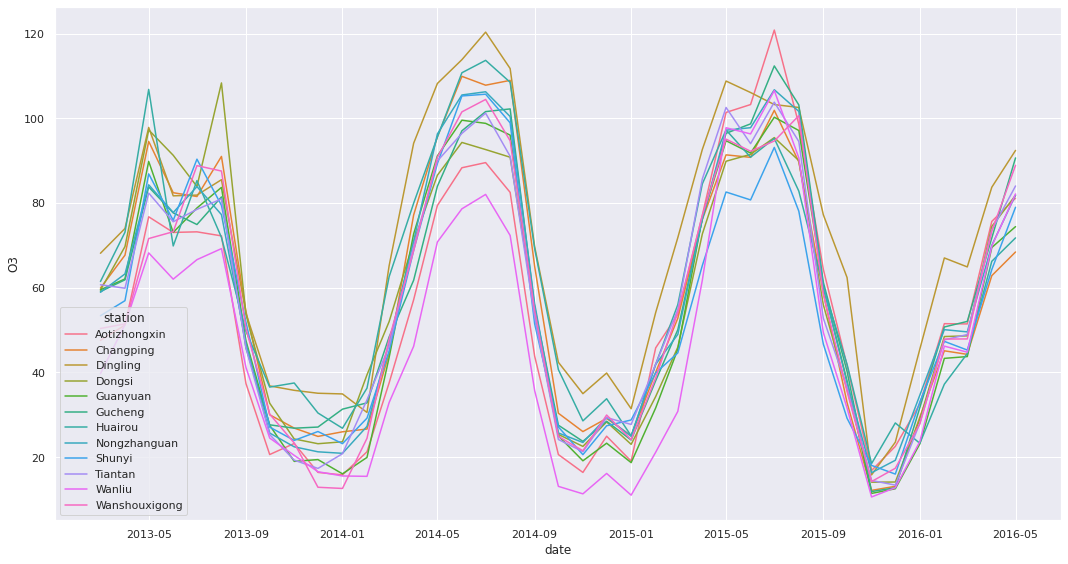

In [82]:
# Plot trend
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="O3",hue="station", data=trend)
plt.tight_layout()
plt.savefig("o3.png")